In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from gensim.models import FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [28]:
# cloudpickle

import cloudpickle

def load_from_pkl( fpath ):
    frb = open(fpath, 'rb')
    obj = cloudpickle.loads(frb.read())
    return obj

def save_as_pkl( obj, fpath ):
    fwb = open( fpath, 'wb')
    tmp = fwb.write(cloudpickle.dumps(obj))
    return

In [29]:
# japanese NLP

import MeCab
mecab = MeCab.Tagger (r"-Ochasen -d ../../model/ipadic-neologd")

import re, unicodedata
import neologdn

def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

def normalize_text( text ):
    text = neologdn.normalize(text)
    text = normalize_number(text)    
    return text

def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text

def get_tokens_pos( text, target_pos ):
    tokens = []
    for line in mecab.parse( text ).split('\n')[:-2]:
        line = line.split('\t')
        pos = line[3].split('-')[0]
        if pos in target_pos: tokens.append( line[2] )
    return tokens

In [30]:
# japanese plot setting

import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.font_manager as fm
fm.findSystemFonts()
font = {"family":"IPAexGothic"}
mpl.rc('font', **font)

In [6]:
# read blog data

dfnogi = pd.read_csv( '../../data/blog/nogizaka46_blog.csv' )
print( dfnogi.shape )

(13028, 6)


In [8]:
# get input text

sentences = []
for idx, text in enumerate( dfnogi['text'].values ):
    if idx % 1000 == 0: print( idx )
    text = clean_text(text)
    text = unicodedata.normalize('NFC', text)
    text = neologdn.normalize(text, repeat=1)
    tokens = get_tokens_pos( text, ['名詞', '動詞', '形容詞'] )
    sentences.append( tokens )
save_as_pkl( sentences, '../../data/blog/nogizaka_blog_nva_sentences.pkl' )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [ ]:
# read blog data

dfkeyaki = pd.read_csv( '../../data/blog/keyakizaka46_blog.csv' )
print( dfkeyaki.shape )

In [ ]:
# get input text

sentences = []
for idx, text in enumerate( dfkeyaki['text'].values ):
    if idx % 1000 == 0: print( idx )
    text = clean_text(text)
    text = unicodedata.normalize('NFC', text)
    text = neologdn.normalize(text, repeat=1)
    tokens = get_tokens_pos( text, ['名詞', '動詞', '形容詞'] )
    sentences.append( tokens )
save_as_pkl( sentences, '../../data/blog/keyakizaka_blog_nva_sentences.pkl' )

In [13]:
# learn fasttext

model = FastText(size=100, sg=1, workers=4, window=10, min_count=10)

sentences = load_from_pkl( '../../data/blog/nogizaka_blog_nva_sentences.pkl' )
sentences += load_from_pkl( '../../data/blog/keyakizaka_blog_nva_sentences.pkl' )

model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [14]:
# save model

model.save( '../../model/fasttext/nogikeyaki_blog_nva.model' )

In [15]:
# test

# model.wv.vocab
model.wv.most_similar("佐々木久美")

[('佐々木希', 0.7091835737228394),
 ('加藤史帆', 0.6711205244064331),
 ('東村', 0.644331693649292),
 ('佐々木', 0.6436366438865662),
 ('柿崎芽実', 0.6401069760322571),
 ('東村芽依', 0.639634907245636),
 ('佐々木美玲', 0.6213143467903137),
 ('久美', 0.6100345849990845),
 ('きくちゃん', 0.5945029258728027),
 ('柿崎', 0.5900822281837463)]

In [16]:
model.wv.most_similar("キャプテン")

[('キャプ', 0.7702136039733887),
 ('暫定', 0.6804853677749634),
 ('就任', 0.6307018399238586),
 ('正式', 0.6078504323959351),
 ('れいか', 0.6019401550292969),
 ('桜井', 0.557970404624939),
 ('大役', 0.5572315454483032),
 ('任命', 0.5523629188537598),
 ('責任感', 0.5509008169174194),
 ('頼り', 0.5480058193206787)]

In [17]:
model.wv.most_similar("てち")

[('友梨奈', 0.7058396935462952),
 ('平手友梨奈', 0.6936807036399841),
 ('平手', 0.6837375164031982),
 ('波布茶', 0.6804182529449463),
 ('ゆう', 0.6743236780166626),
 ('ネル', 0.6728752255439758),
 ('鈴本', 0.6586591005325317),
 ('理佐', 0.645741879940033),
 ('まなか', 0.6427689790725708),
 ('あかね', 0.6317785978317261)]

In [18]:
# omake

In [19]:
def plot_with_label( X_tmp, y_tmp, d1, d2 ): # , groups
    fig = plt.figure(figsize=(6,4),dpi=200)
    plt.scatter(X_tmp[:, d1], X_tmp[:, d2], alpha=0.5)

    for i, cat in enumerate( y_tmp ):
        plt.annotate( s=cat, xy=(X_tmp[i, d1],X_tmp[i, d2]), ha='right', va='bottom',
            bbox=dict(boxstyle='round, pad=0.05', fc='orange', alpha=0.6),fontsize=6,
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    plt.show()

In [58]:
member_list = dfkeyaki['author'].unique().tolist()
member_list = member_list + ['土田', '澤部', '春日', '若林']

In [59]:
# fasttext features

X = np.zeros( ( len(member_list), 100 ) )
for i, m in enumerate( member_list ):
    X[i] = model[m]
# X[np.isnan(X)] = 0.0

C:\Users\myaun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


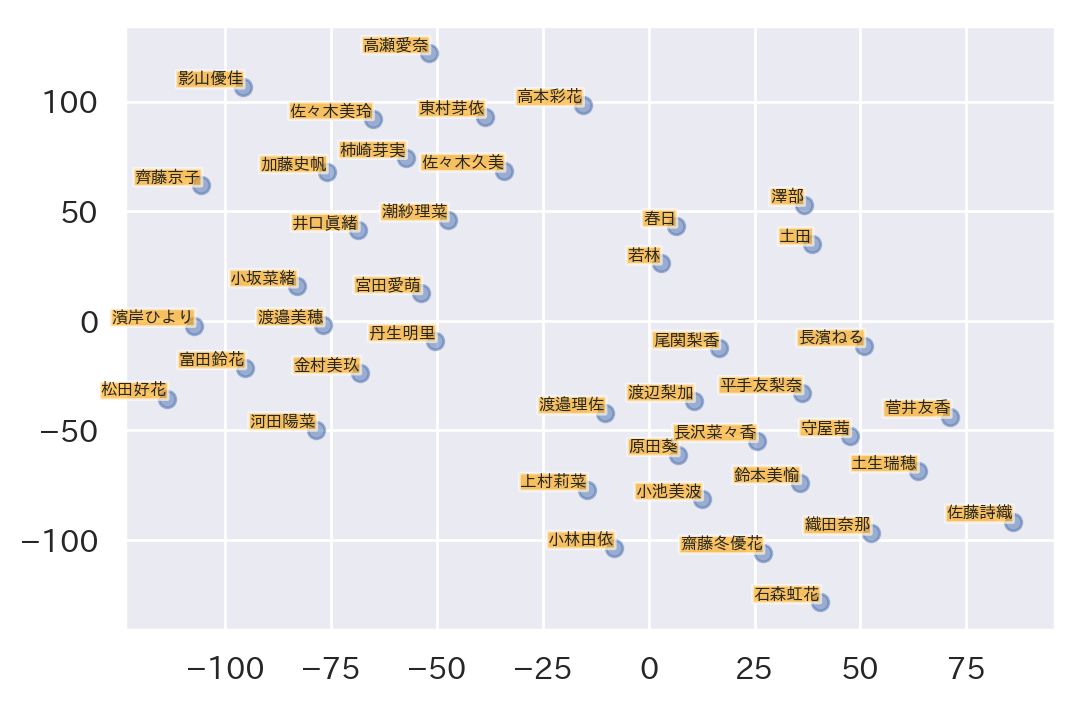

In [60]:
# dimensionality reduction

# pca = PCA(); pca.fit(X); Xr = pca.fit_transform( X )
Xr = TSNE(n_components=2, perplexity=20, random_state=0).fit_transform( X )
plot_with_label( Xr, member_list, 0, 1 )

In [53]:
member_list = dfnogi['author'].unique().tolist()
member_list = member_list + dfkeyaki['author'].unique().tolist()
member_list = member_list + ['設楽', '日村', '土田', '澤部', '春日', '若林']

In [54]:
# fasttext features

X = np.zeros( ( len(member_list), 100 ) )
for i, m in enumerate( member_list ):
    X[i] = model[m]
# X[np.isnan(X)] = 0.0

C:\Users\myaun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


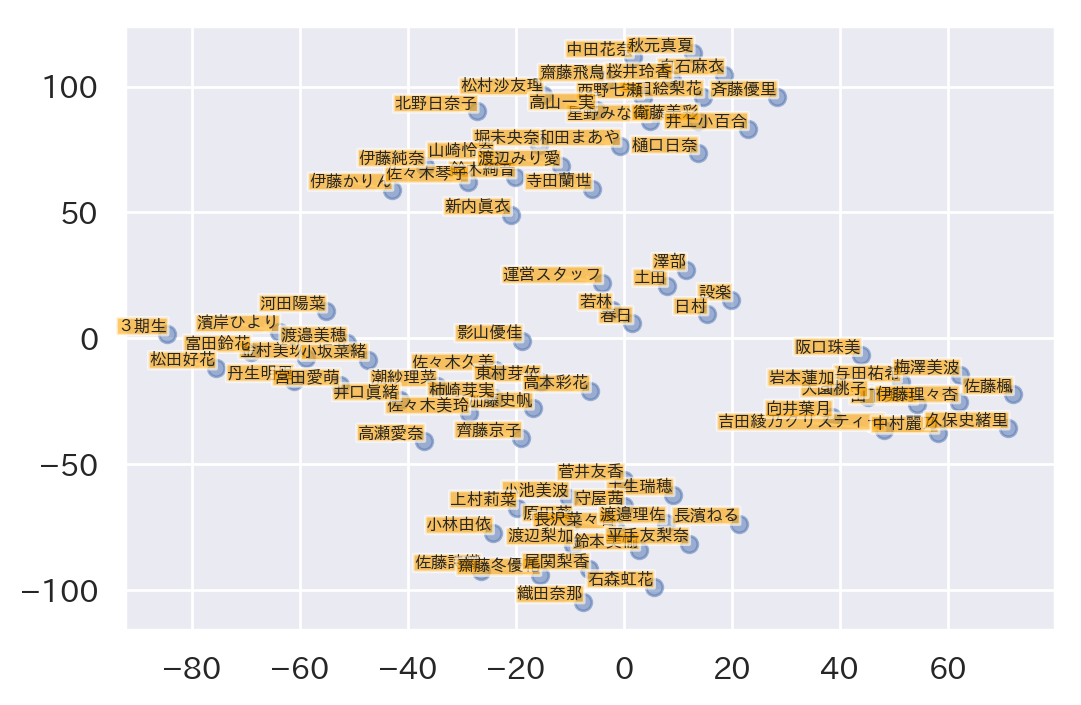

In [56]:
# dimensionality reduction

# pca = PCA(); pca.fit(X); Xr = pca.fit_transform( X )
Xr = TSNE(n_components=2, perplexity=20, random_state=0).fit_transform( X )
plot_with_label( Xr, member_list, 0, 1 )